In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.1, img_size=224)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 1)
(2686, 15)
(299, 224, 224, 1)
(299, 15)


In [4]:
# a classic CNN model
model_name = 'classic_CNN'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0         
__________

In [5]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
epochs = 200
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/200
 - 15s - loss: 2.6846 - acc: 0.1456 - val_loss: 2.3842 - val_acc: 0.2207

Epoch 00001: val_loss improved from inf to 2.38421, saving model to ./saved_models/classic_CNN.h5
Epoch 2/200
 - 12s - loss: 2.3511 - acc: 0.2307 - val_loss: 2.1053 - val_acc: 0.3411

Epoch 00002: val_loss improved from 2.38421 to 2.10532, saving model to ./saved_models/classic_CNN.h5
Epoch 3/200
 - 12s - loss: 2.1497 - acc: 0.3143 - val_loss: 1.9423 - val_acc: 0.3779

Epoch 00003: val_loss improved from 2.10532 to 1.94231, saving model to ./saved_models/classic_CNN.h5
Epoch 4/200
 - 12s - loss: 2.0370 - acc: 0.3558 - val_loss: 1.7992 - val_acc: 0.4415

Epoch 00004: val_loss improved from 1.94231 to 1.79922, saving model to ./saved_models/classic_CNN.h5
Epoch 5/200
 - 12s - loss: 1.9711 - acc: 0.3787 - val_loss: 1.7244 - val_acc: 0.4615

Epoch 00005: val_loss improved from 1.79922 to 1.72443, saving model to ./saved_models/classic_CNN.h5
Epoch 6/200
 - 12s - loss: 1.9060 - acc: 0.4158 - val_loss: 1.68

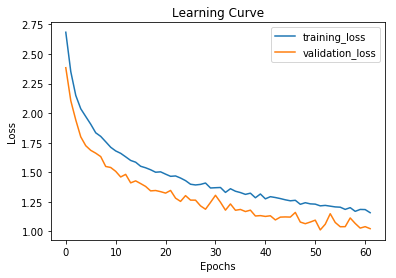

In [6]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

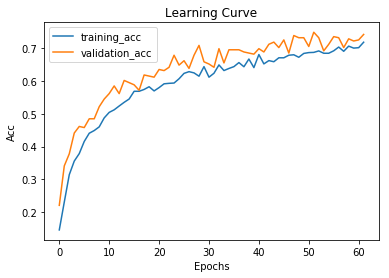

In [7]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [8]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 3ms/step
Validation loss: 1.0121175766389905
Validation accuracy: 0.7491638795986622


In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_9 (Activation)    (None, 112, 112, 128)     0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
epochs = 200
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/200
 - 13s - loss: 2.4133 - acc: 0.2328 - val_loss: 2.3016 - val_acc: 0.2977

Epoch 00001: val_loss improved from inf to 2.30156, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
Epoch 2/200
 - 12s - loss: 2.0220 - acc: 0.3730 - val_loss: 1.8624 - val_acc: 0.4281

Epoch 00002: val_loss improved from 2.30156 to 1.86236, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
Epoch 3/200
 - 12s - loss: 1.8446 - acc: 0.4427 - val_loss: 1.8110 - val_acc: 0.4214

Epoch 00003: val_loss improved from 1.86236 to 1.81105, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
Epoch 4/200
 - 12s - loss: 1.7671 - acc: 0.4771 - val_loss: 1.7758 - val_acc: 0.4314

Epoch 00004: val_loss improved from 1.81105 to 1.77577, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
Epoch 5/200
 - 12s - loss: 1.6865 - acc: 0.5120 - val_loss: 1.6891 - val_acc: 0.4849

Epoch 00005: val_loss improved from 1.77577 to 1.68907, saving model to ./

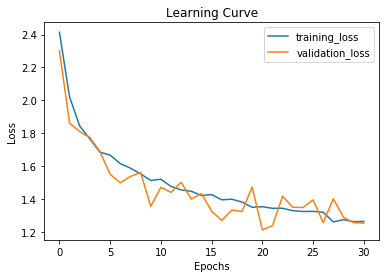

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

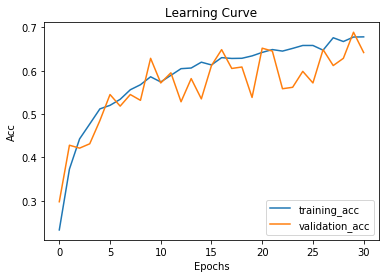

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 1.2147647293913724
Validation accuracy: 0.6521739128441316
